<a href="https://colab.research.google.com/github/fernanda0402/Doutorado/blob/main/ALFALFA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A partir dos dados do Hemisfério Norte do ALFALFA, vamos calcular $\delta_m$. Para isso, vamos calcular a densidade $\rho_i$ por cascas de raio igual a 10 Mpc. São fornecidos os valores das massas dos objetos e sabemos que o volume de cada casca é dado por:

$V_{casca} = \frac{V_E ^{maior} - V_E ^{menor}}{\theta/180º}$,

em que $\theta$ é o ângulo de abertura do cone. No caso do Hemisfério Norte, $\theta$ = 135º.

Logo, tendo os dados da massa e conhecendo o volume de cada casca, é possível calcular $\rho_i$ e, consequentemente, $\delta_i$ por casca.

Lembrando que a expressão para calcular o contraste $\delta$ é:

$\delta_i = \frac{\rho_i - \bar{\rho}}{\bar{\rho}}$,

em que $\rho_i$ é a densidade de cada casca e $\bar{\rho}$ é a densidade média.

In [ ]:
import urllib.request #usar biblioteca Pandas para ler o arquivo como um DataFrame e pular a primeira linha com o cabeçalho
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import sympy as sm
import scipy as sp
import math
from matplotlib import rc

In [ ]:
# extraindo os dados do drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
alfalfa = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/a100.code12.table2.190808_modificado_code1_RA_110-250 - HN.csv', sep=',')
alfalfa

,AGCNr,Name,RAdeg_HI,DECdeg_HI,RAdeg_OC,DECdeg_OC,Vhelio,W50,sigW,W20,HIflux,sigflux,SNR,RMS,Dist,sigDist,logMH,siglogMH,HIcode
0,174577,........,110.34333,7.92194,110.34583,7.92139,4930,209,6,236,3.33,0.10,20.9,2.46,72.2,2.3,9.61,0.05,1
1,12926,FGC.629.,111.14958,6.15028,111.15000,6.14889,3845,226,5,244,3.77,0.13,16.5,3.39,57.3,2.2,9.46,0.06,1
2,3839,057-011.,111.29124,9.51167,111.29333,9.51583,5264,200,5,215,3.14,0.09,19.6,2.53,76.8,2.4,9.64,0.05,1
3,170326,057-010.,111.31000,9.20750,111.29708,9.20444,14002,218,70,269,1.97,0.12,11.5,2.59,202.8,2.2,10.28,0.05,1
4,174578,........,111.35708,9.80444,111.35792,9.80472,8564,135,9,166,3.15,0.08,22.5,2.69,125.1,2.2,10.06,0.05,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16280,10495,052-057.,249.85791,7.29056,249.86082,7.28444,13519,495,21,514,2.86,0.16,8.8,2.92,193.8,2.1,10.40,0.05,1
16281,265128,........,250.00792,24.03417,250.00456,24.03278,10983,204,22,216,2.13,0.12,10.2,3.28,157.3,2.3,10.09,0.05,1
16282,262738,........,250.08748,28.47222,250.09248,28.47167,964,32,11,71,0.60,0.05,10.5,2.16,18.6,2.3,7.69,0.12,1
16283,262737,........,250.09291,28.76417,250.08917,28.76556,963,80,2,92,4.23,0.09,29.1,3.59,18.6,2.2,8.54,0.11,1


In [ ]:
# nomeando dados/colunas
massa = alfalfa['logMH']
distancia = alfalfa['Dist']

# definindo constantes
c = 2.9*10**5 # velocidade da luz
h0 = 70 #km/s/Mpc

# definindo o redshift
z = (distancia*h0)/c

# vamos verificar os valores máximo e mínimo do redshift
print('O valor máximo do redshift é', z.max())
print('O valor mínimo do redshift é', z.min())

# agora vamos verificar o valor máximo da distância para saber até qual distância faremos o corte
print('O valor máximo de distância é', distancia.max())

O valor máximo do redshift é 0.062155172413793106
O valor mínimo do redshift é 9.655172413793103e-05
O valor máximo de distância é 257.5


array([[<Axes: title={'center': 'Dist'}>]], dtype=object)

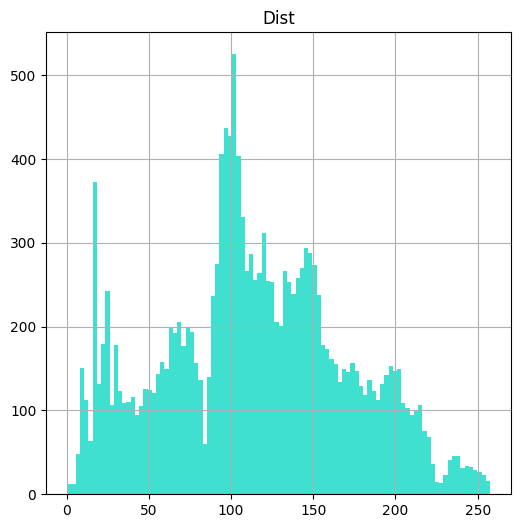

In [ ]:
# histograma dos dados
values = pd.DataFrame(distancia)
values.hist( bins=100, color='turquoise', figsize=(6, 6))

array([[<Axes: title={'center': 'logMH'}>]], dtype=object)

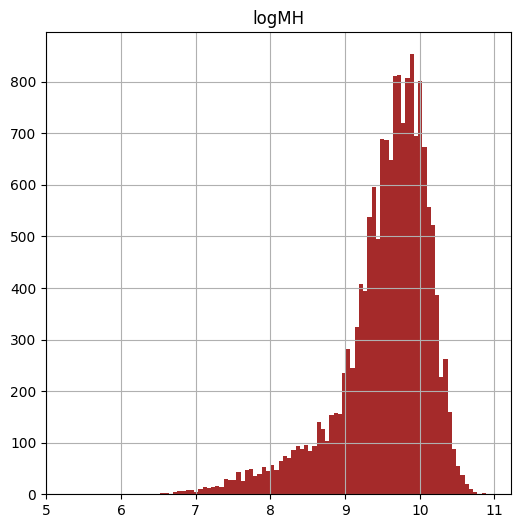

In [ ]:
# histograma dos dados
values = pd.DataFrame(massa)
values.hist( bins=100, color='brown', figsize=(6, 6))

In [ ]:
# calculando a densidade média
volume_total = (4*np.pi*(250**3))/3 - (4*np.pi*(10**3))/3
massa_total = np.sum(massa)
densidade_media = massa_total/volume_total
print(densidade_media)

0.0023724504324091032


Vamos fazer o primeiro recorte: entre 10 Mpc e 20 Mpc.

In [ ]:
mask = (distancia <= 20) & (distancia >= 10)
distancia_mask = distancia[mask]
massa_mask = np.sum(massa[mask])
z_mask = z[mask]
print(len(distancia_mask))  # quantidade de dados entre 10 e 20 Mpc
#print(z_mask)

volume_casca1 = ((4*np.pi*(20**3))/3 - (4*np.pi*(10**3))/3)/(135/180)
print(volume_casca1)

densidade_casca1 = massa_mask/volume_casca1
print(densidade_casca1)

contraste1 = (densidade_casca1 - densidade_media)/densidade_media
print(contraste1)

r = np.arange(0,100,10)
print(r)

rb = (r[1:]+r[:-1])/2
print(rb)

695
39095.375244672985
0.14491483876400352
60.082346246049845
[ 0 10 20 30 40 50 60 70 80 90]
[ 5. 15. 25. 35. 45. 55. 65. 75. 85.]


Vamos fazer o segundo recorte: entre 20 Mpc e 30 Mpc.

In [ ]:
mask2 = (distancia <= 30) & (distancia >= 20)
distancia_mask2 = distancia[mask2]
massa_mask2 = np.sum(massa[mask2])
z_mask2 = z[mask2]
print(len(distancia_mask2))   # quantidade de dados entre 20 e 30 Mpc

volume_casca2 = ((4*np.pi*(30**3))/3 - (4*np.pi*(20**3))/3)/(135/180)
print(volume_casca2)

densidade_casca2 = massa_mask2/volume_casca2
print(densidade_casca2)

contraste2 = (densidade_casca2 - densidade_media)/densidade_media
print(contraste2)

681
106116.01852125523
0.05487588095696977
22.130464690571465


Vamos fazer o terceiro recorte: entre 30 Mpc e 40 Mpc.

In [ ]:
mask3 = (distancia <= 40) & (distancia >= 30)
distancia_mask3 = distancia[mask3]
massa_mask3 = np.sum(massa[mask3])
z_mask3 = z[mask3]
print(len(distancia_mask3))  # quantidade de dados entre 30 e 40 Mpc

volume_casca3 = ((4*np.pi*(40**3))/3 - (4*np.pi*(30**3))/3)/(135/180)
print(volume_casca3)

densidade_casca3 = massa_mask3/volume_casca3
print(densidade_casca3)

contraste3 = (densidade_casca3 - densidade_media)/densidade_media
print(contraste3)

490
206646.9834361286
0.02084845337861716
7.78772980620152


Vamos fazer o quarto recorte: entre 40 Mpc e 50 Mpc.

In [ ]:
mask4 = (distancia <= 50) & (distancia >= 40)
distancia_mask4 = distancia[mask4]
massa_mask4 = np.sum(massa[mask4])
z_mask4 = z[mask4]
print(len(distancia_mask4))  # quantidade de dados entre 40 e 50 Mpc

volume_casca4 = ((4*np.pi*(50**3))/3 - (4*np.pi*(40**3))/3)/(135/180)
print(volume_casca4)

densidade_casca4 = massa_mask4/volume_casca4
print(densidade_casca4)

contraste4 = (densidade_casca4 - densidade_media)/densidade_media
print(contraste4)

413
340688.26998929307
0.01092145027510614
3.603447189417551


Vamos fazer o quinto recorte: entre 50 Mpc e 60 Mpc.

In [ ]:
mask5 = (distancia <= 60) & (distancia >= 50)
distancia_mask5 = distancia[mask5]
massa_mask5 = np.sum(massa[mask5])
z_mask5 = z[mask5]
print(len(distancia_mask5))  # quantidade de dados entre 50 e 60 Mpc

volume_casca5 = ((4*np.pi*(60**3))/3 - (4*np.pi*(50**3))/3)/(135/180)
print(volume_casca5)

densidade_casca5 = massa_mask5/volume_casca5
print(densidade_casca5)

contraste5 = (densidade_casca5 - densidade_media)/densidade_media
print(contraste5)

548
508239.87818074884
0.009830141660436992
3.1434550227694245


Vamos fazer o sexto recorte: entre 60 Mpc e 70 Mpc.

In [ ]:
mask6 = (distancia <= 70) & (distancia >= 60)
distancia_mask6 = distancia[mask6]
massa_mask6 = np.sum(massa[mask6])
z_mask6 = z[mask6]
print(len(distancia_mask6))  # quantidade de dados entre 60 e 70 Mpc

volume_casca6 = ((4*np.pi*(70**3))/3 - (4*np.pi*(60**3))/3)/(135/180)
print(volume_casca6)

densidade_casca6 = massa_mask6/volume_casca6
print(densidade_casca6)

contraste6 = (densidade_casca6 - densidade_media)/densidade_media
print(contraste6)

743
709301.8080104954
0.009663629674405929
3.0732693684112093


Vamos fazer o sétimo recorte: entre 70 Mpc e 80 Mpc.

In [ ]:
mask7 = (distancia <= 80) & (distancia >= 70)
distancia_mask7 = distancia[mask7]
massa_mask7 = np.sum(massa[mask7])
z_mask7 = z[mask7]
print(len(distancia_mask7))  # quantidade de dados entre 70 e 80 Mpc

volume_casca7 = ((4*np.pi*(80**3))/3 - (4*np.pi*(70**3))/3)/(135/180)
print(volume_casca7)

densidade_casca7 = massa_mask7/volume_casca7
print(densidade_casca7)

contraste7 = (densidade_casca7 - densidade_media)/densidade_media
print(contraste7)

715
943874.0594785335
0.007066832627739677
1.9787061222449511


Vamos fazer o oitavo corte: 80 Mpc a 90 Mpc

In [ ]:
mask8 = (distancia <= 90) & (distancia >= 80)
distancia_mask8 = distancia[mask8]
massa_mask8 = np.sum(massa[mask8])
z_mask8 = z[mask8]
print(len(distancia_mask8))  # quantidade de dados entre 80 e 90 Mpc

volume_casca8 = ((4*np.pi*(90**3))/3 - (4*np.pi*(80**3))/3)/(135/180)
print(volume_casca8)

densidade_casca8 = massa_mask8/volume_casca8
print(densidade_casca8)

contraste8 = (densidade_casca8 - densidade_media)/densidade_media
print(contraste8)

561
1211956.6325848624
0.004372540945378205
0.8430483881334925


Vamos fazer o nono corte: 90 Mpc a 100 Mpc

In [ ]:
mask9 = (distancia <= 100) & (distancia >= 90)
distancia_mask9 = distancia[mask9]
massa_mask9 = np.sum(massa[mask9])
z_mask9 = z[mask9]
print(len(distancia_mask9))  # quantidade de dados entre 90 e 100 Mpc

volume_casca9 = ((4*np.pi*(100**3))/3 - (4*np.pi*(90**3))/3)/(135/180)
print(volume_casca9)

densidade_casca9 = massa_mask9/volume_casca9
print(densidade_casca9)

contraste9 = (densidade_casca9 - densidade_media)/densidade_media
print(contraste9)

1474
1513549.5273294821
0.009272917566670905
2.908582215247687


Vamos fazer o décimo corte: 100 Mpc a 110 Mpc

In [ ]:
mask10 = (distancia <= 110) & (distancia >= 100)
distancia_mask10 = distancia[mask10]
massa_mask10 = np.sum(massa[mask10])
z_mask10 = z[mask10]
print(len(distancia_mask10))  # quantidade de dados entre 100 e 110 Mpc

volume_casca10 = ((4*np.pi*(110**3))/3 - (4*np.pi*(100**3))/3)/(135/180)
print(volume_casca10)

densidade_casca10 = massa_mask10/volume_casca10
print(densidade_casca10)

contraste10 = (densidade_casca10 - densidade_media)/densidade_media
print(contraste10)

1553
1848652.7437123936
0.008054595461827066
2.395053212407069


Vamos fazer o décimo primeiro corte: 110 Mpc a 120 Mpc

In [ ]:
mask11 = (distancia <= 120) & (distancia >= 100)
distancia_mask11 = distancia[mask11]
massa_mask11 = np.sum(massa[mask11])
z_mask11 = z[mask11]
print(len(distancia_mask11))  # quantidade de dados entre 110 e 120 Mpc

volume_casca11 = ((4*np.pi*(120**3))/3 - (4*np.pi*(110**3))/3)/(135/180)
print(volume_casca11)

densidade_casca11 = massa_mask11/volume_casca11
print(densidade_casca11)

contraste11 = (densidade_casca11 - densidade_media)/densidade_media
print(contraste11)

2615
2217266.281733597
0.011342584428035648
3.7809573903374782


Vamos fazer o décimo segundo corte: 120 Mpc a 130 Mpc

In [ ]:
mask12 = (distancia <= 130) & (distancia >= 120)
distancia_mask12 = distancia[mask12]
massa_mask12 = np.sum(massa[mask12])
z_mask12 = z[mask12]
print(len(distancia_mask12))  # quantidade de dados entre 120 e 130 Mpc

volume_casca12 = ((4*np.pi*(130**3))/3 - (4*np.pi*(120**3))/3)/(135/180)
print(volume_casca12)

densidade_casca12 = massa_mask12/volume_casca12
print(densidade_casca12)

contraste12 = (densidade_casca12 - densidade_media)/densidade_media
print(contraste12)

931
2619390.141393089
0.0034713461947917788
0.4631901882421217


Vamos fazer o décimo terceiro corte: 130 Mpc a 140 Mpc

In [ ]:
mask13 = (distancia <= 140) & (distancia >= 130)
distancia_mask13 = distancia[mask13]
massa_mask13 = np.sum(massa[mask13])
z_mask13 = z[mask13]
print(len(distancia_mask13))  

volume_casca13 = ((4*np.pi*(140**3))/3 - (4*np.pi*(130**3))/3)/(135/180)
print(volume_casca13)

densidade_casca13 = massa_mask13/volume_casca13
print(densidade_casca13)

contraste13 = (densidade_casca13 - densidade_media)/densidade_media
print(contraste13)

978
3055024.3226908743
0.0031362270764380713
0.32193576464035606


Vamos fazer o décimo quarto corte: 140 Mpc a 150 Mpc

In [ ]:
mask14 = (distancia <= 150) & (distancia >= 140)
distancia_mask14 = distancia[mask14]
massa_mask14 = np.sum(massa[mask14])
z_mask14 = z[mask14]
print(len(distancia_mask14))  

volume_casca14 = ((4*np.pi*(150**3))/3 - (4*np.pi*(140**3))/3)/(135/180)
print(volume_casca14)

densidade_casca14 = massa_mask14/volume_casca14
print(densidade_casca14)

contraste14 = (densidade_casca14 - densidade_media)/densidade_media
print(contraste14)

1098
3524168.825626952
0.0030646119792739034
0.2917496346433443


Vamos fazer o décimo quinto corte: 150 Mpc a 160 Mpc

In [ ]:
mask15 = (distancia <= 160) & (distancia >= 150)
distancia_mask15 = distancia[mask15]
massa_mask15 = np.sum(massa[mask15])
z_mask15 = z[mask15]
print(len(distancia_mask15))  

volume_casca15 = ((4*np.pi*(160**3))/3 - (4*np.pi*(150**3))/3)/(135/180)
print(volume_casca15)

densidade_casca15 = massa_mask15/volume_casca15
print(densidade_casca15)

contraste15 = (densidade_casca15 - densidade_media)/densidade_media
print(contraste15)

822
4026823.6502013155
0.0020199618127288367
-0.14857575731195874


Vamos fazer o décimo sexto corte: 160 Mpc a 170 Mpc

In [ ]:
mask16 = (distancia <= 170) & (distancia >= 160)
distancia_mask16 = distancia[mask16]
massa_mask16 = np.sum(massa[mask16])
z_mask16 = z[mask16]
print(len(distancia_mask16))  

volume_casca16 = ((4*np.pi*(170**3))/3 - (4*np.pi*(160**3))/3)/(135/180)
print(volume_casca16)

densidade_casca16 = massa_mask16/volume_casca16
print(densidade_casca16)

contraste16 = (densidade_casca16 - densidade_media)/densidade_media
print(contraste16)

598
4562988.796413978
0.0013021136507434356
-0.45115243169856023


Vamos fazer o décimo sétimo corte: 170 Mpc a 180 Mpc

In [ ]:
mask17 = (distancia <= 180) & (distancia >= 170)
distancia_mask17 = distancia[mask17]
massa_mask17 = np.sum(massa[mask17])
z_mask17 = z[mask17]
print(len(distancia_mask17))  

volume_casca17 = ((4*np.pi*(180**3))/3 - (4*np.pi*(170**3))/3)/(135/180)
print(volume_casca17)

densidade_casca17 = massa_mask17/volume_casca17
print(densidade_casca17)

contraste17 = (densidade_casca17 - densidade_media)/densidade_media
print(contraste17)

567
5132664.264264922
0.0011052447048789079
-0.5341337000003883


Vamos fazer o décimo oitavo corte: 180 Mpc a 190 Mpc

In [ ]:
mask18 = (distancia <= 190) & (distancia >= 180)
distancia_mask18 = distancia[mask18]
massa_mask18 = np.sum(massa[mask18])
z_mask18 = z[mask18]
print(len(distancia_mask18))  

volume_casca18 = ((4*np.pi*(190**3))/3 - (4*np.pi*(180**3))/3)/(135/180)
print(volume_casca18)

densidade_casca18 = massa_mask18/volume_casca18
print(densidade_casca18)

contraste18 = (densidade_casca18 - densidade_media)/densidade_media
print(contraste18)

485
5735850.053754166
0.0008486989642997804
-0.6422690427137946


Vamos fazer o décimo nono corte: 190 Mpc a 200 Mpc

In [ ]:
mask19 = (distancia <= 200) & (distancia >= 190)
distancia_mask19 = distancia[mask19]
massa_mask19 = np.sum(massa[mask19])
z_mask19 = z[mask19]
print(len(distancia_mask19))  

volume_casca19 = ((4*np.pi*(200**3))/3 - (4*np.pi*(190**3))/3)/(135/180)
print(volume_casca19)

densidade_casca19 = massa_mask19/volume_casca19
print(densidade_casca19)

contraste19 = (densidade_casca19 - densidade_media)/densidade_media
print(contraste19)

559
6372546.164881691
0.0008844565192890429
-0.6271970502705416


Vamos fazer o vigésimo corte: 200 Mpc a 210 Mpc

In [ ]:
mask20 = (distancia <= 210) & (distancia >= 200)
distancia_mask20 = distancia[mask20]
massa_mask20 = np.sum(massa[mask20])
z_mask20 = z[mask20]
print(len(distancia_mask20))  

volume_casca20 = ((4*np.pi*(210**3))/3 - (4*np.pi*(200**3))/3)/(135/180)
print(volume_casca20)

densidade_casca20 = massa_mask20/volume_casca20
print(densidade_casca20)

contraste20 = (densidade_casca20 - densidade_media)/densidade_media
print(contraste20)

464
7042752.597647523
0.000667117002174601
-0.7188067691272363


Vamos fazer o vigésimo primeiro corte: 210 Mpc a 220 Mpc

In [ ]:
mask21 = (distancia <= 220) & (distancia >= 210)
distancia_mask21 = distancia[mask21]
massa_mask21 = np.sum(massa[mask21])
z_mask21 = z[mask21]
print(len(distancia_mask21))  

volume_casca21 = ((4*np.pi*(220**3))/3 - (4*np.pi*(210**3))/3)/(135/180)
print(volume_casca21)

densidade_casca21 = massa_mask21/volume_casca21
print(densidade_casca21)

contraste21 = (densidade_casca21 - densidade_media)/densidade_media
print(contraste21)

362
7746469.352051626
0.0004748705291173382
-0.7998396414819376


Vamos fazer o vigésimo segundo corte: 220 Mpc a 230 Mpc

In [ ]:
mask22 = (distancia <= 230) & (distancia >= 220)
distancia_mask22 = distancia[mask22]
massa_mask22 = np.sum(massa[mask22])
z_mask22 = z[mask22]
print(len(distancia_mask22))  

volume_casca22 = ((4*np.pi*(230**3))/3 - (4*np.pi*(220**3))/3)/(135/180)
print(volume_casca22)

densidade_casca22 = massa_mask22/volume_casca22
print(densidade_casca22)

contraste22 = (densidade_casca22 - densidade_media)/densidade_media
print(contraste22)

106
8483696.428094039
0.00012724995633094964
-0.9463634921123584


Vamos fazer o vigésimo terceiro corte: 230 Mpc a 240 Mpc

In [ ]:
mask23 = (distancia <= 240) & (distancia >= 230)
distancia_mask23 = distancia[mask23]
massa_mask23 = np.sum(massa[mask23])
z_mask23 = z[mask23]
print(len(distancia_mask23))  

volume_casca23 = ((4*np.pi*(240**3))/3 - (4*np.pi*(230**3))/3)/(135/180)
print(volume_casca23)

densidade_casca23 = massa_mask23/volume_casca23
print(densidade_casca23)

contraste23 = (densidade_casca23 - densidade_media)/densidade_media
print(contraste23)

153
9254433.825774739
0.00016959546413619828
-0.9285146438385299


Vamos fazer o vigésimo quarto corte: 240 Mpc a 250 Mpc

In [ ]:
mask24 = (distancia <= 250) & (distancia >= 240)
distancia_mask24 = distancia[mask24]
massa_mask24 = np.sum(massa[mask24])
z_mask24 = z[mask24]
print(len(distancia_mask24))  

volume_casca24 = ((4*np.pi*(250**3))/3 - (4*np.pi*(240**3))/3)/(135/180)
print(volume_casca24)

densidade_casca24 = massa_mask24/volume_casca24
print(densidade_casca24)

contraste24 = (densidade_casca24 - densidade_media)/densidade_media
print(contraste24)

127
10058681.545093715
0.0001298589675141992
-0.9452637805451076


In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()
!mamba install pyccl

✨🍰✨ Everything looks OK!

                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (1.1.0) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ['pyccl']

conda-forge/linux-64                                        Usin

In [ ]:
import pyccl as ccl

In [ ]:
cosmo = ccl.Cosmology(
    Omega_c=0.2656, Omega_b=0.0494, h=0.6727, sigma8=0.8120, n_s=0.9649) 


a = np.linspace(0.94, 1, 1000)  # fator de escala
delta = ccl.growth_factor(cosmo, a)  # contraste

# definindo o redshift em função do fator de escala
z1 = (1/a) - 1.

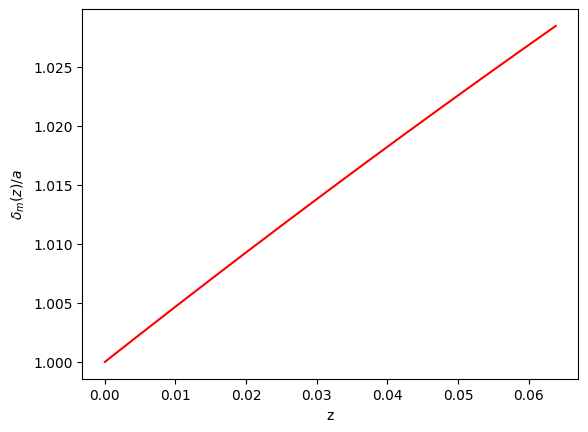

In [ ]:
# fazendo o plot de delta/a x z usando o pyccl
plt.plot(z1, delta/a, color='red')
plt.xlabel('z')
plt.ylabel('$\delta_m(z)/a$')
plt.show()

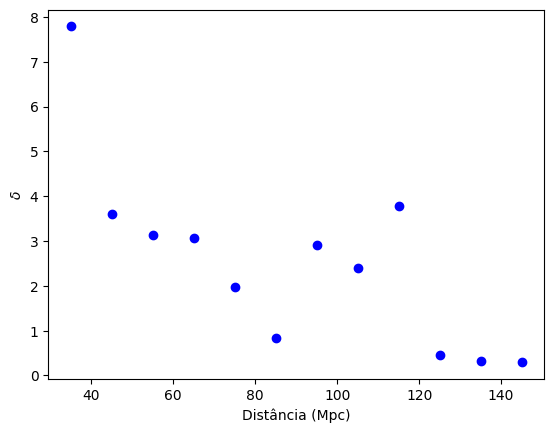

In [ ]:
x1 = np.array([contraste3, contraste4, contraste5, contraste6, contraste7, contraste8, contraste9, contraste10, contraste11, contraste12, contraste13, contraste14])
y1 = np.array([35, 45, 55, 65, 75, 85, 95, 105, 115, 125, 135, 145])

plt.scatter(y1, x1, color='blue')
plt.xlabel('Distância (Mpc)')
plt.ylabel('$\delta$')
plt.show()

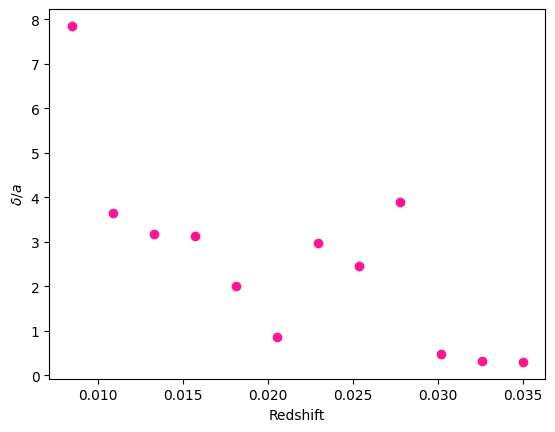

In [ ]:
# constantes
h0 = 70 #km/s/Mpc
c = 2.9*10**5 # velocidade da luz

z2 = (h0/c)*y1  # redshift
x2 = (1+z2)*x1  # delta*(1+z)

plt.scatter(z2, x2, color='deeppink')
plt.xlabel('Redshift')
plt.ylabel('$\delta/a$')
plt.show()

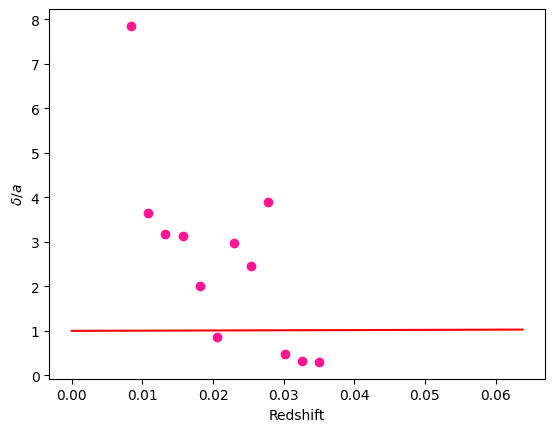

In [ ]:
plt.scatter(z2, x2, color='deeppink')
plt.plot(z1, delta/a, color='red')
plt.xlabel('Redshift')
plt.ylabel('$\delta/a$')
plt.show()